# Ajuste-fino da Arquitetura do Modelo e Hiperparâmetros RP

Com o estudo anterior (17), consolidamos a melhor `Taxa de Amostragem (= 5)` e o melhor `Tamanho de Janela` para cada aparelho da `residência 3` na base REDD.

Apesar de resultados satisfatórios, o processo de otimização considerou um pipeline canônico, escolhido aleatoriamente, composto de:
* Um conversor de séries em imagens baseado em Gráfico de Recorrência;
* Um modelo classificador baseado em CNN.

Neste sentido, a adoção de uma estratégia sistemática para escolha da arquitetura do modelo classificador e explotar diferentes combinações de hiperparâmetros do Gráfico de recorrência tendem a culminar em resultados de ponta para a identificação de cargas.

Portanto, neste estudo temos os seguintes objetivos:
1. Construir um modelo baseado em Deep Learning utilizando um arcabouço sistemático;
2. Varrer um conjunto discreto de valores combinatórios dos hiperparâmetros do RP.

# Configurações

In [1]:
import os
import sys
import gc
from pprint import pprint
from collections import Counter
import copy
import warnings
warnings.filterwarnings(action="ignore")

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from IPython.display import display

# TODO: implementar rotina na classe PyNILM.utils
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

def listar_variaveis_memoria(ambiente):
    print("* Variáveis instanciadas em memória:")
    print("---")
    total = 0
    for name, size in sorted(((name, sys.getsizeof(value)) for name, value in ambiente.items()),
                             key= lambda x: -x[1])[:10]:
        total += size
        print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))
    print("---")
    print("Total:", sizeof_fmt(total))
    
# TODO: implementar na classe utils
def highlight_col(x):
    r = 'background-color: #D9D9D9'
    df1 = pd.DataFrame('', index=x.index, columns=x.columns)
    df1.iloc[:, -2] = r
    return df1   

In [2]:
# CONSTANTES FUNDAMENTAIS DE ORGANIZACAO DE PASTAS/ARQUIVOS

# Path do arquivo H5 (base REDD ja preparada p/ NILMTK) e outros insumos fundamentais
caminho_dados = "D:/Projetos/phd-thesis/datasets/"

# Definir diretorios onde iremos salvar os insumos gerados do notebook (dados, imagens, etc.)
caminho_dados_notebook = os.path.join(caminho_dados, "18") # Num. notebook
if not os.path.isdir(caminho_dados_notebook):
    os.makedirs(caminho_dados_notebook)
caminho_imagens_notebook = os.path.join(caminho_dados_notebook, "imagens") # Num. notebook
if not os.path.isdir(caminho_imagens_notebook):
    os.makedirs(caminho_imagens_notebook)

# Path do arquivo H5 (base REDD ja preparada p/ NILMTK)
caminho_redd = os.path.join(caminho_dados, "REDD/low_freq")

# Path completo do arquivo REDD
arquivo_dataset = os.path.join(caminho_redd, "redd.h5")

# VARIAVEL AUXILIAR
# Path dos arquivos relacionados as janelas
caminho_janelas = os.path.join(caminho_redd, "../../phd")
if not os.path.isdir(caminho_janelas):
    os.makedirs(caminho_janelas)

# Dados

## Base REDD

In [3]:
# Exemplo de carregamento da base REDD no NILMTK
from nilmtk import DataSet
from nilmtk.utils import print_dict
from nilmtk.dataset_converters import convert_redd

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from PyNILM.dados.janelas import Janelas

# Gerar arquivo H5 (Nilmtk) do dataset REDD, caso n exista
if not os.path.isfile(arquivo_dataset):
    print("Gerando arquivo H5 (NILMTK) da base REDD, aguarde...")
    print("-----")
    convert_redd(caminho_redd, arquivo_dataset)

# Carregando dataset REDD no objeto NILMTK
redd = DataSet(arquivo_dataset)
print("NILMTK -> Detalhes sobre o dataset REDD:")
print_dict(redd.metadata)
print()

# Parametros dos dados
PARAMETROS_DATASET = {
    "base":redd,
    "id_residencia":3,
    "inicio_intervalo":'2011-04-16 05:11:30',
    "fim_intervalo":'2011-04-23 08:43:26',
    "debug": False    
}
print("PARÂMETROS DO ESTUDO:")
pprint(PARAMETROS_DATASET)

NILMTK -> Detalhes sobre o dataset REDD:



PARÂMETROS DO ESTUDO:
{'base': <nilmtk.dataset.DataSet object at 0x0000023B6D49FE48>,
 'debug': False,
 'fim_intervalo': '2011-04-23 08:43:26',
 'id_residencia': 3,
 'inicio_intervalo': '2011-04-16 05:11:30'}


## Melhores Janelas para cada aparelho (estudo 17)

In [4]:
df_melhores_janelas = pd.read_csv(os.path.join(caminho_dados, "17", "taxa_5-melhoresjanelas.csv"))
df_melhores_janelas

,taxa_amostragem,carga,janela,loss,acuracia,f1_macro
0,5,sockets - 3,1080,0.103,93.10,73.15
1,5,sockets - 4,30,0.000,100.00,100.00
2,5,light - 5,1080,0.018,100.00,100.00
3,5,ce_appliance - 6,360,0.000,100.00,100.00
4,5,fridge - 7,360,0.000,100.00,100.00
5,5,waste_disposal_unit - 8,30,0.099,99.81,49.95
6,5,dish_washer - 9,60,0.092,97.67,74.40
7,5,electric_furnace - 10,30,1.154,90.70,82.94
8,5,light - 11,30,7.155,82.76,79.20
9,5,sockets - 12,30,2.086,85.96,67.43


## Preparando Janelas utilizadas no Experimento

Consumo geral dos medidores/aparelhos no período:


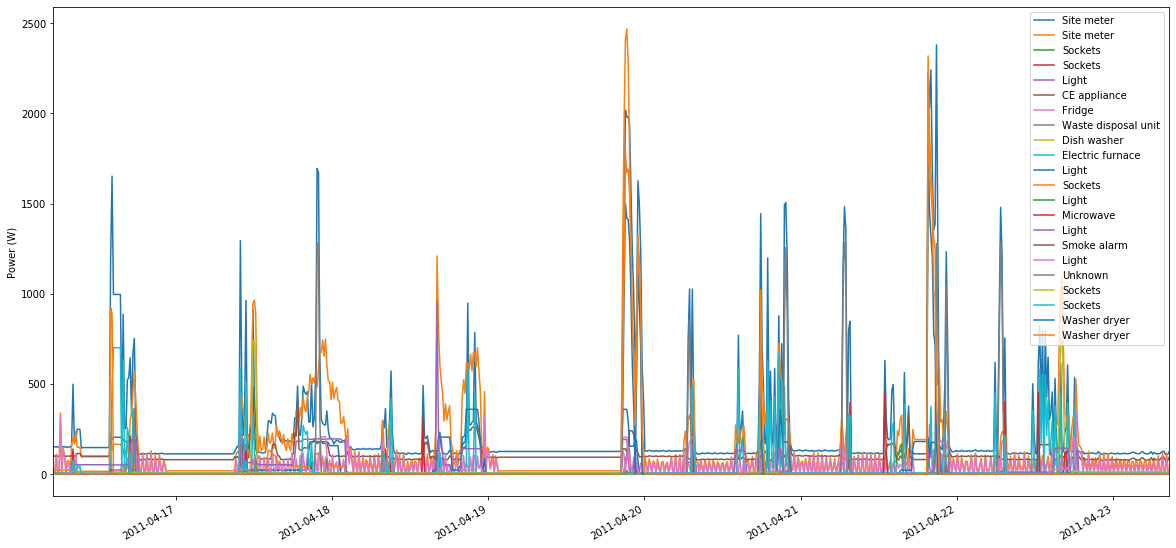

In [4]:
# Teste da classe
janelas = Janelas(
    base=redd,
    id_residencia=3,
    inicio_intervalo='2011-04-16 05:11:30',
    fim_intervalo='2011-04-23 08:43:26',
    debug = False
)


# Plots
fig = plt.figure(figsize=(20, 10))
print("Consumo geral dos medidores/aparelhos no período:")
for m in range(len(janelas.residencia.elec.meters)):
    janelas.residencia.elec.meters[m].plot();

In [5]:
# Extrair series divididas em janelas para cada medidor
# a cada 90 segundos, em uma taxa de 3s
dados_cargas = janelas.preparar(taxa_amostral=3, intervalo_medicao=90)

# Disposicao das janelas preparadas
pprint(dados_cargas)

Loading data for meter ElecMeterID(instance=2, building=3, dataset='REDD')     
Done loading data all meters for this chunk.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.
[{'carga': 'site_meter',
  'instancia': 1,
  'janelas': array([[144.82    , 146.66667 , 146.01    , ..., 162.76666 , 160.01666 ,
        153.06667 ],
       [152.77666 , 152.92667 , 153.16333 , ..., 152.35666 , 152.29001 ,
        152.03667 ],
       [152.01    , 152.95334 , 153.31    , ..., 152.32666 , 152.03    ,
        152.45999 ],
       ...,
       [107.815   , 107.939995, 107.86    , ..., 108.13    , 108.130005,
        108.19    ],
       [108.11    , 108.22    , 108.096664, ..., 122.235   , 122.27334 ,
        122.47667 ],
       [122.39667 , 122.57333 , 121.11    , ..., 123.916664, 123.66    ,
        135.86333 ]], dtype=float32),
  'rotulos': {'estado': array([1, 1, 1, ..., 1, 1, 1]),
              'media': array([147.

## Preparando Amostras (medidores residência ) e Rótulos (aparelhos)

In [6]:
# Listando as cargas que possuem janelas preparadas
janelas.lista_cargas(dados_cargas)

[(1, 'site_meter'),
 (2, 'site_meter'),
 (3, 'sockets'),
 (4, 'sockets'),
 (5, 'light'),
 (6, 'ce_appliance'),
 (7, 'fridge'),
 (8, 'waste_disposal_unit'),
 (9, 'dish_washer'),
 (10, 'electric_furnace'),
 (11, 'light'),
 (12, 'sockets'),
 (13, 'washer_dryer'),
 (14, 'washer_dryer'),
 (15, 'light'),
 (16, 'microwave'),
 (17, 'light'),
 (18, 'smoke_alarm'),
 (19, 'light'),
 (20, 'unknown')]

In [7]:
# Filtrando dados para conjunto de cargas
# NOTA: Os lares norte-americanos têm suprimentos de energia em fase dividida. 
#   Cada divisão é de 120 volts em relação ao neutro. As duas divisões 
#   totalizam 240 volts, por isso os dois 'site_meter'. 
#
#   Além disso, aparelhos que demandam energia (secadora, por exemplo) podem se 
#   conectar a ambas as divisões; na REDD se mede separadamente as duas divisões 
#   para esses tais aparelhos, contemplando no NILMTK dois medidores por 
#   dispositivo de 240 volts.

# Apenas duas fases da corrente eletrica da residencia
dados_medidores = janelas.filtrar_cargas(
    dados_cargas,
    filtros=[
        (1, 'site_meter'),
        (2, 'site_meter'),    
    ]
)
print("Dados das janelas de ambos medidores da residência:")
print("---")
pprint(dados_medidores)

print("\n\n")

# Apenas dados de aparelhos da residencia
dados_aparelhos = janelas.filtrar_cargas(
    dados_cargas,
    filtros=[
        (3, 'sockets'),
        (4, 'sockets'),
        (5, 'light'),
        (6, 'ce_appliance'),
        (7, 'fridge'),
        (8, 'waste_disposal_unit'),
        (9, 'dish_washer'),
        (10, 'electric_furnace'),
        (11, 'light'),
        (12, 'sockets'),
        (13, 'washer_dryer'),
        (14, 'washer_dryer'),
        (15, 'light'),
        (16, 'microwave'),
        (17, 'light'),
        (18, 'smoke_alarm'),
        (19, 'light'),
        (20, 'unknown')
    ]
)
print("Dados das janelas dos aparelhos da residência:")
print("---")
pprint(dados_aparelhos)

Dados das janelas de ambos medidores da residência:
---
[{'carga': 'site_meter',
  'instancia': 1,
  'janelas': array([[144.82    , 146.66667 , 146.01    , ..., 162.76666 , 160.01666 ,
        153.06667 ],
       [152.77666 , 152.92667 , 153.16333 , ..., 152.35666 , 152.29001 ,
        152.03667 ],
       [152.01    , 152.95334 , 153.31    , ..., 152.32666 , 152.03    ,
        152.45999 ],
       ...,
       [107.815   , 107.939995, 107.86    , ..., 108.13    , 108.130005,
        108.19    ],
       [108.11    , 108.22    , 108.096664, ..., 122.235   , 122.27334 ,
        122.47667 ],
       [122.39667 , 122.57333 , 121.11    , ..., 123.916664, 123.66    ,
        135.86333 ]], dtype=float32),
  'rotulos': {'estado': array([1, 1, 1, ..., 1, 1, 1]),
              'media': array([147.05612, 153.01077, 152.7641 , ..., 107.80511, 116.91384,
       122.40183], dtype=float32),
              'total': array([4411.6836, 4590.323 , 4582.923 , ..., 3234.1533, 3507.4153,
       3672.055 ], dtype

              'media': array([1.        , 1.        , 1.        , ..., 0.96666664, 0.96666664,
       1.        ], dtype=float32),
              'total': array([30., 30., 30., ..., 29., 29., 30.], dtype=float32)}},
 {'carga': 'unknown',
  'instancia': 20,
  'janelas': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
  'rotulos': {'estado': array([0, 0, 0, ..., 0, 0, 0]),
              'media': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
              'total': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)}}]


In [8]:

# Janelas do medidores agregados
X = dados_medidores[0]["janelas"] + dados_medidores[1]["janelas"]

# Normalizando dados
# X = MinMaxScaler().fit_transform(X.T).T

print("* Dados dos medidores (Amostras / X):")
print("   - Shape:", X.shape)
print("   - Media:", np.mean(X))
print("   - Desvio:", np.std(X))

# Y = irá depender da carga a ser classificada

* Dados dos medidores (Amostras / X):
   - Shape: (6861, 30)
   - Media: 413.0859
   - Desvio: 673.9321


In [9]:
# Verificar apenas janelas válidaso: com medicao total MAIOR QUE ZERO 
# (ou seja, amostras que possuam ao menos uma carga ativa - janelas zeradas
# são INÚTEIS para aprendizado do modelo, além de contribuir para desbalanceamento)
idx_janelas_validas = np.where(np.sum(X, axis=1)>0)[0]
print("* Janelas com TODOS aparelhos desligados: {} (~{:.1f}% das amostras)".format(
    X.shape[0] - len(idx_janelas_validas), 
    ( 1 - (len(idx_janelas_validas)/X.shape[0]) )*100 
))
print()

# AMOSTRAS -> Filtrando apenas JANELAS validas
X = X[idx_janelas_validas]
print("* Amostras validadas (X shape):", X.shape)
print()

# APARELHOS -> Filtrando apenas JANELAS validas
print("* Rotulos (estado) validados:")
for i in range(len(dados_aparelhos)):
    
    dados_aparelhos[i]["janelas"] = dados_aparelhos[i]["janelas"][idx_janelas_validas]
    
    rotulos = copy.deepcopy(dados_aparelhos[i]["rotulos"])
    
    dados_aparelhos[i]["rotulos"]["estado"] = rotulos["estado"][idx_janelas_validas]
    dados_aparelhos[i]["rotulos"]["media"]  = rotulos["media"][idx_janelas_validas]
    dados_aparelhos[i]["rotulos"]["total"]  = rotulos["total"][idx_janelas_validas]
    print("   - `{}-{}`: {} -> {}".format(
        dados_aparelhos[i]["carga"].upper(), dados_aparelhos[i]["instancia"],
        Counter(rotulos["estado"]), 
        Counter(dados_aparelhos[i]["rotulos"]["estado"])
    ))

* Janelas com TODOS aparelhos desligados: 0 (~0.0% das amostras)

* Amostras validadas (X shape): (6861, 30)

* Rotulos (estado) validados:
   - `SOCKETS-3`: Counter({0: 4497, 1: 2364}) -> Counter({0: 4497, 1: 2364})
   - `SOCKETS-4`: Counter({0: 5858, 1: 1003}) -> Counter({0: 5858, 1: 1003})
   - `LIGHT-5`: Counter({0: 6092, 1: 769}) -> Counter({0: 6092, 1: 769})
   - `CE_APPLIANCE-6`: Counter({1: 6861}) -> Counter({1: 6861})
   - `FRIDGE-7`: Counter({1: 5844, 0: 1017}) -> Counter({1: 5844, 0: 1017})
   - `WASTE_DISPOSAL_UNIT-8`: Counter({0: 6138, 1: 723}) -> Counter({0: 6138, 1: 723})
   - `DISH_WASHER-9`: Counter({1: 6339, 0: 522}) -> Counter({1: 6339, 0: 522})
   - `ELECTRIC_FURNACE-10`: Counter({1: 6833, 0: 28}) -> Counter({1: 6833, 0: 28})
   - `LIGHT-11`: Counter({0: 5056, 1: 1805}) -> Counter({0: 5056, 1: 1805})
   - `SOCKETS-12`: Counter({0: 4866, 1: 1995}) -> Counter({0: 4866, 1: 1995})
   - `WASHER_DRYER-13`: Counter({0: 6613, 1: 248}) -> Counter({0: 6613, 1: 248})
   - `WAS

In [10]:
# TOP-5 aparelhos com maior consumo
top_aparelhos_consumo = []
for m in janelas.residencia.elec.submeters().select_top_k(5).meters:
    instancia = m.instance()
    carga = m.label().lower().replace(" ","_")
    if type(instancia)==tuple and len(instancia) > 1:
        for i in instancia:
            top_aparelhos_consumo.append((i, carga))
    else:
        top_aparelhos_consumo.append((instancia, carga))
        
print("\n")
print("------------------------------------------------------------------")
print("* Top-5 aparelhos com maior consumo total de energia no intervalo:")
print("------------------------------------------------------------------")
pprint(top_aparelhos_consumo)
print("----------------------------------------------")

19/19 MeterGroup(meters==22, building=3, dataset='REDD', appliances=[Appliance(type='sockets', instance=5)])1)])1)])])
  ElecMeter(instance=13, building=3, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
  ElecMeter(instance=14, building=3, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
Calculating total_energy for ElecMeterID(instance=14, building=3, dataset='REDD') ...   

------------------------------------------------------------------
* Top-5 aparelhos com maior consumo total de energia no intervalo:
------------------------------------------------------------------
[(6, 'ce_appliance'),
 (13, 'washer_dryer'),
 (14, 'washer_dryer'),
 (7, 'fridge'),
 (10, 'electric_furnace'),
 (17, 'light')]
----------------------------------------------


**Distribuções dos estados (rótulos classificação):**

   - `CE_APPLIANCE-6`&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;: {1: 5264}
   - `FRIDGE-7`&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;: {1: 5125, 0: 139}
   - `ELECTRIC_FURNACE-10`: {1: 5236, 0: 28}
   - `WASHER_DRYER-13`&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;: {0: 5018, 1: 246}
   - `WASHER_DRYER-14`&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;: {0: 4945, 1: 319}
   - `LIGHT-17`&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;: {0: 3134, 1: 2130})
   
   
<u>**CONCLUSÕES PARCIAIS:**</u>
1. É possível perceber que o aparelho `CE_APPLIANCE-6` é inviável de treinar nestas configurações, pois há apenas amostras positivas;
2. `LIGHT-17` é o aparelho com melhor equlibrio de amostras, ou seja, possui menor grau de desbalanceamento;
3. De resto, todos os aparelhos possuem grande desbalanceamento; `talvez seja necessário avaliar individualmente o tamanho da janela considerada para cada aparelho`.
    * Corrobora [Fagiani *et. al* (2019)](https://www.mdpi.com/1996-1073/12/7/1371), os quais afirmam que *"(...) geralmente, apesar da tarefa a ser resolvida dependendo da formulação do algoritmo, a precisão da desagregação diminui proporcionalmente com a variação da taxa de amostragem."*

Portanto, vamos considerar avaliar diferentes 'sample rate' em um pipeline de classificação (RP+CNN) comum neste estudo, considerando as cargas de maior consumo.

In [11]:
# Eletrônicos, Luzes, refrigerador, lava loucas, aquecedor, secadora de
# roupas, alarmes de incêndio, equipamentos de banheiro, utensílios de
# cozinha, Micro-ondas, utensílios externos.

In [12]:
# # TOP-5 aparelhos com maior DEMANDA de energia
# df_energia = janelas.residencia.elec.dataframe_of_meters()

# fig = plt.figure(figsize=(20,8))
# cargas = janelas.residencia.elec.get_labels(df_energia.columns)[2:]
# legenda = []
# dados_energia = [] # Lista com estatisticas por caga
# for i, coluna in enumerate(df_energia.columns[2:]):
#     instancia = ""
#     if hasattr(coluna, "instance"):
#         instancia = coluna.instance
#     else:
#         instancia = tuple([m.instance for m in coluna.meters])

#     serie = np.nan_to_num(df_energia[coluna].values)
#     dados_energia.append({
#         "carga": cargas[i],
#         "instancia": instancia,
#         "total": np.sum(serie),
#         "maximo": np.max(serie),
#         "minimo": np.min(serie),
#         "media": np.mean(serie),
#         "desvio": np.std(serie)
#     })
#     legenda.append(f"{cargas[i]}-{str(instancia)}")
#     plt.plot(np.arange(df_energia.shape[0]), serie)
# plt.legend(legenda);
# plt.title("Consumo por Dispositivo dentro do Intervalo")
# plt.show();

# sorted(dados_energia, key=lambda k: k['maximo'], reverse=False) 

## Transformar Séries (Janelas) em Imagens

In [397]:

# fig, axes = plt.subplots(1,4, figsize=(20,5))

# axes[0].plot(np.arange(len(X[3])), X[3])
# axes[0].set_title("Série Original (Janela)")
# # axes[0].grid(False)

# # RPs
# X_rp = RecurrencePlot().fit_transform(X)
# axes[1].imshow(X_rp[3], cmap="plasma");
# axes[1].set_title("RP")
# axes[1].grid(False)

# # GASF
# X_gasf = GramianAngularField(method="summation").fit_transform(X)
# axes[2].imshow(X_gasf[3], cmap="plasma");
# axes[2].set_title("GASF")
# axes[2].grid(False)

# # GASF
# X_gadf = GramianAngularField(method="difference").fit_transform(X)
# axes[3].imshow(X_gadf[3], cmap="plasma");
# axes[3].set_title("GADF")
# axes[3].grid(False)

# # # MTF
# # X_mtf = MarkovTransitionField().fit_transform(X[np.where(np.sum(X, axis=1)>0)[0]])
# # plt.imshow(X_mtf[3], cmap="plasma");
# # plt.title("MTF")
# # plt.grid(False)
# # plt.show()
# plt.show()

# # Gerando imagens RGB N canais
# X_imagem = np.stack([X_rp, X_gasf, X_gadf], axis=-1)
# print("* Shape da matriz de amostras:", X_imagem.shape)

# Construção da Arquitetura do Modelo de DL
---

Nesta etapa, iremos considerar apenas um aparelho a fim de direcionar os esforços de modo eficiente. Sendo assim, iremos escolher o aparelho com base em dois parâmetros: 1) os que mais consomem energia na medição histórica (dentre as cinco do paper IEEE); e 2) que possui maior equilíbrio nas amostras (visando avaliação mais justa).

In [5]:
# from PyNILM.dados.janelas import Janelas

from PyNILM.avaliacao.metricas import *
from PyNILM.avaliacao.graficos import *
from PyNILM.avaliacao.analises import *

from sklearn.model_selection import train_test_split

from pyts.image import RecurrencePlot

import tensorflow as tf
# from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, Conv1D, MaxPooling2D, MaxPool1D
# from tensorflow.keras.utils import to_categorical
# from tensorflow.keras import backend as K
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard


from pyts.image import RecurrencePlot, GramianAngularField

# Garantindo reprodutibilidade
import random as rn
# Constantes dos experimentos
SEED = 33
FRACAO_TESTE = 0.25
EPOCAS = 100
TAMANHO_LOTE = 32
VERBOSIDADE = 0
PARAMETROS_RP = {
    "dimension": 1,
    "time_delay": 1,
    "threshold": None,
    "percentage": 10
}
# PARAMETROS_RP={
#     "dimension": 3,
#     "time_delay": 8,
#     "threshold": 0.1
# }
# Travar Seed's
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""
np.random.seed(SEED)
rn.seed(SEED)
os.environ['PYTHONHASHSEED']=str(SEED)
tf.random.set_seed(SEED)

# Habilitando/limitando utilização de GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only allocate 4GB of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*0.5)]
        )
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print("# GPUs habilitadas:", "{} física(s)".format(len(gpus)), "/", "{} lógica(s)".format(len(gpus)))
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

# GPUs habilitadas: 1 física(s) / 1 lógica(s)


## Selecionando os dados de um dos aparelhos

In [6]:
# Escolhendo aparelho (conforme enunciado)
# -------------------

# Intervalo de tempo e residencia considerados na base REDD
janelas = Janelas(**PARAMETROS_DATASET)

# 1) Para cada aparelho dos considerados no paper IEE GM
for i, r in df_melhores_janelas.loc[
    (df_melhores_janelas["carga"].isin([
                "fridge - 7", "dish_washer - 9", "washer_dryer - 13", 
                "washer_dryer - 14", "microwave - 16"
            ])), :
].iterrows():
    
    # Informacoes da carga (nome, id, taxa e janela)
    carga = r["carga"].split(" - ")[0]
    instancia = int(r["carga"].split(" - ")[1])
    taxa = r["taxa_amostragem"]
    janela = r["janela"]
    print(f"* `{r['carga'].upper()}` / taxa={taxa} e janela={janela}...")
          
    # 2) Carregar dados e verificar distribuição DA CARGA / JANELA
    
    # Extrair series divididas em janelas para cada medidor
    dados_cargas = janelas.preparar(taxa_amostral=taxa, intervalo_medicao=janela)
    print()
    
    # Escolhendo apenas dados do aparelho
    dados_aparelho = janelas.filtrar_cargas(dados_cargas, filtros=[(instancia, carga)])
    # Analise dos dados
    distribuicao = dict(Counter(dados_aparelho[0]["rotulos"]["estado"]))
    maioritaria = max(distribuicao, key=distribuicao.get)
    minoritaria = 1 - maioritaria
    print(
        "  -> Distribuição:", distribuicao, 
        "(índice de equilíbrio = {:.2f}%)".format(
            (distribuicao[minoritaria]/distribuicao[maioritaria])*100
        )
    )

    print()

* `FRIDGE - 7` / taxa=5 e janela=360...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

  -> Distribuição: {1: 266, 0: 77} (índice de equilíbrio = 28.95%)

* `DISH_WASHER - 9` / taxa=5 e janela=60...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

  -> Distribuição: {0: 2031, 1: 27} (índice de equilíbrio = 1.33%)

* `WASHER_DRYER - 13` / taxa=5 e janela=60...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

  -> Distribuição: {0: 2011, 1: 47} (índice de equilíbrio = 2.34%)

* `WASHER_DRYER - 14` / taxa=5 e janela=30...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

  -> Distribuição: {0: 3988, 1: 128} (índice de equilíbrio = 3.21%)

* `

**NOTA:** será selecionado o aparelho `fridge - 7`, dado que este é o que possui o conjunto de dados mais equilibrado.

## Preparando os dados do aparelho selecionado - `fridge`

Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.



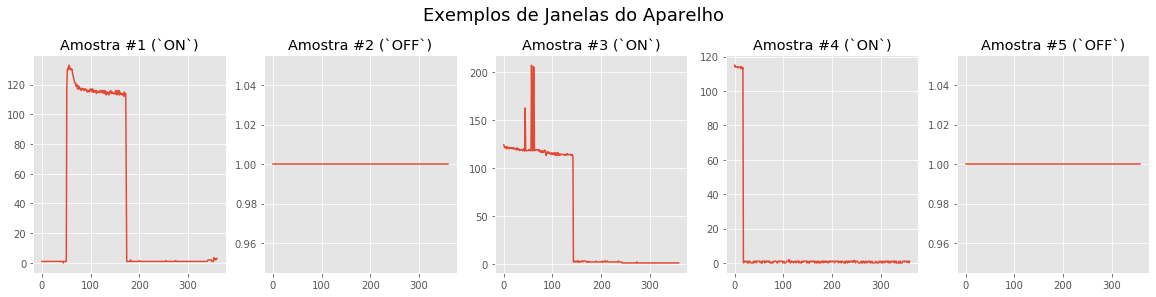

In [657]:
# Constantes referente aos dados da carga selecionada
TAXA = 5
TAMANHO_JANELA = 360

# Extrair series divididas em janelas para cada medidor
dados_cargas = janelas.preparar(
    taxa_amostral=TAXA, 
    intervalo_medicao=TAMANHO_JANELA
)
print()
dados_aparelho = janelas.filtrar_cargas(dados_cargas, filtros=[(7, "fridge")])[0]

# Fazendo split dos dados (treino/teste)
X_treino, X_teste, y_treino, y_teste = train_test_split(
    dados_aparelho["janelas"], dados_aparelho["rotulos"]["estado"],
    test_size=FRACAO_TESTE,
    stratify=dados_aparelho["rotulos"]["estado"],
    random_state=SEED
)

# Construindo datasets (treino e teste)
dataset_treino = tf.data.Dataset.from_tensor_slices((X_treino, y_treino))
dataset_teste = tf.data.Dataset.from_tensor_slices((X_teste, y_teste))

del X_treino
del y_treino
del X_teste
del y_teste
del dados_cargas
del dados_aparelho

# Exibindo algumas amostras de janealas
num_amostras = 5
fig, axes = plt.subplots(1, num_amostras, figsize=(20,4))
estados = {1: "ON", 0: "OFF"}
for i,amostra in enumerate(dataset_treino.shuffle(33).take(num_amostras)):
    serie = amostra[0].numpy()
    estado = amostra[1].numpy()
    axes[i].plot(np.arange(0, serie.shape[0]), serie)
    axes[i].set_title(f"Amostra #{i+1} (`{estados[estado]}`)")
plt.suptitle("Exemplos de Janelas do Aparelho", size=18, y=1.05)
plt.show()

**NOTA:** Interessante observar que algumas amostras estão rotuladas como `OFF` mesmo possuindo alguma curva no gráfico ou variação maior que 0. Isto ocorre pois tais sinais são tratados como ruído pela biblioteca NILMTK (conforme a baixa amplitude da medição), base do pré-processamento da PyNILM. Logo, é observado que os dados foram tratados corretamente.

In [658]:
# Construindo o pipeline de dados
# ----------

import cv2

# Constante fundamentais
TAMANHO_IMAGEM = (32,32,1) # Apenas 1 canal
TIPO_DADOS = np.float32
def serie_para_imagem(serie, params_rp = PARAMETROS_RP, tam_imagem=TAMANHO_IMAGEM):
    """
    Funcao responsavel por gerar e tratar a imagem RP.
    """
    # Gerando imagem RP/redimensionando
    imagem = RecurrencePlot(**params_rp).fit_transform([serie])[0]
    imagem = cv2.resize(
            imagem, 
            dsize=tam_imagem[:2], 
            interpolation=cv2.INTER_CUBIC
        ).astype(TIPO_DADOS)

    return np.stack([imagem for i in range(tam_imagem[-1])],axis=-1) # N canais

def preparar_amostra(amostra, rotulo):
    """
    Preparação da amostra/rótulo para o modelo.
    """
    # Convertendo serie para imagem
    amostra = tf.numpy_function(serie_para_imagem, [amostra], TIPO_DADOS)
    amostra = tf.reshape(amostra, TAMANHO_IMAGEM)
    return amostra, rotulo

# pipelines consolidados
dataset_treino = dataset_treino.map(lambda amostra, rotulo: preparar_amostra(amostra, rotulo))
dataset_teste = dataset_teste.map(lambda amostra, rotulo: preparar_amostra(amostra, rotulo))

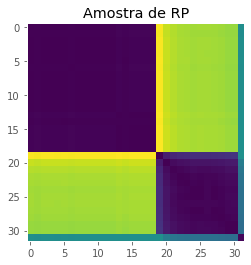

In [659]:
# Exemplo de amostra processada no pipeline
for a in dataset_treino.shuffle(SEED).batch(1).take(1):
    rp = a[0][0].numpy()
    plt.imshow(rp[:,:,0])
    plt.grid(False)
    plt.title("Amostra de RP")
    break

## Construindo o modelo

### Buscando o Overfitting

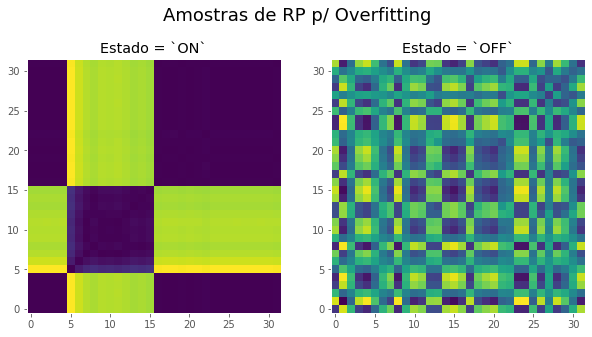

In [668]:
X,y = [], []

for amostra in dataset_treino.shuffle(SEED):
    imagem = amostra[0].numpy()
    rotulo = amostra[1].numpy()
    # Verificar se N possui amostra da classe
    if y.count(rotulo) == 0:
        X.append(imagem)
        y.append(rotulo)
    
    # Verificar se ja possui condicao de parada (1 de cada classe)
    if np.unique(y).shape[0] == 2:
        break
        
# Amostras selecionadas
fig, axes  = plt.subplots(1,2, figsize=(10,5))
axes[0].imshow(X[0][:,:,0], origin="lower")
axes[0].set_title(f"Estado = `{estados[y[0]]}`")
axes[0].grid(False)
axes[1].imshow(X[1][:,:,0], origin="lower")
axes[1].set_title(f"Estado = `{estados[y[1]]}`")
axes[1].grid(False)
plt.suptitle("Amostras de RP p/ Overfitting", size=18, y=1.0);

In [669]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, \
                    Dropout, MaxPool2D, AveragePooling2D, Flatten, Dense
from tensorflow.keras.constraints import max_norm

def modelo_baseline(optimizer, loss='binary_crossentropy', metrics=['accuracy'], name="Baseline"):
    
    model = Sequential(name=name)

    model.add(Conv2D(32, kernel_size=(3,3), strides=(1,1), padding="valid", kernel_initializer = 'he_uniform', input_shape=(32,32,1), kernel_constraint=max_norm(3), bias_constraint=max_norm(3)))
    model.add(BatchNormalization(trainable=False))
    model.add(Activation("relu"))
    model.add(AveragePooling2D())
    
#     model.add(Conv2D(32, kernel_size=(2,2), padding="valid", kernel_initializer = 'he_uniform', kernel_constraint=max_norm(3), bias_constraint=max_norm(3)))
#     model.add(BatchNormalization(trainable=False))
#     model.add(Activation("relu"))
#     model.add(MaxPool2D())
    
    model.add(Flatten())
    model.add(Dense(128))
    model.add(BatchNormalization(trainable=False))
    model.add(Activation("relu"))
    #model.add(Dropout(0.2))
 
    # Output
    model.add(Dense(1, activation = 'sigmoid'))
    
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    return model

In [675]:
modelo_overfitting = modelo_baseline(optimizer=tf.keras.optimizers.RMSprop(1e-2, momentum=0.5))

print("* Detalhes do modelo:")
print("---")
print(modelo_overfitting.summary())
print()

* Detalhes do modelo:
---
Model: "Baseline"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_106 (Conv2D)          (None, 30, 30, 32)        320       
_________________________________________________________________
batch_normalization_176 (Bat (None, 30, 30, 32)        128       
_________________________________________________________________
activation_176 (Activation)  (None, 30, 30, 32)        0         
_________________________________________________________________
average_pooling2d_11 (Averag (None, 15, 15, 32)        0         
_________________________________________________________________
flatten_67 (Flatten)         (None, 7200)              0         
_________________________________________________________________
dense_137 (Dense)            (None, 128)               921728    
_________________________________________________________________
batch_normalization_177 (Bat (No

In [676]:
print("* Treinando:")
print("---")
historico = modelo_overfitting.fit(
    np.asarray(X).astype(TIPO_DADOS), np.array(y),
    epochs=10,
    verbose=2    
)

* Treinando:
---
Train on 2 samples
Epoch 1/10
2/2 - 1s - loss: 0.6455 - accuracy: 0.5000
Epoch 2/10
2/2 - 0s - loss: 11006.9902 - accuracy: 0.5000
Epoch 3/10
2/2 - 0s - loss: 392.5878 - accuracy: 0.5000
Epoch 4/10
2/2 - 0s - loss: 70.4679 - accuracy: 0.5000
Epoch 5/10
2/2 - 0s - loss: 68.7413 - accuracy: 0.5000
Epoch 6/10
2/2 - 0s - loss: 41.2835 - accuracy: 0.5000
Epoch 7/10
2/2 - 0s - loss: 2.2631 - accuracy: 0.5000
Epoch 8/10
2/2 - 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9/10
2/2 - 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 10/10
2/2 - 0s - loss: 0.0000e+00 - accuracy: 1.0000


### Ajustando hiperparâmetros no conjunto completo

In [680]:
print("* Treinando modelo:")
print("---")
modelo = modelo_baseline(optimizer=tf.keras.optimizers.RMSprop(1e-2, momentum=0.5))
historico = modelo.fit(
    dataset_treino.batch(TAMANHO_LOTE),
    validation_data=dataset_teste.batch(TAMANHO_LOTE),
    epochs=100,
    verbose=2    
)

* Treinando modelo:
---
Train for 9 steps, validate for 3 steps
Epoch 1/100
9/9 - 1s - loss: 4.7669 - accuracy: 0.8949 - val_loss: 2661.7066 - val_accuracy: 0.5349
Epoch 2/100
9/9 - 0s - loss: 157.6881 - accuracy: 0.9611 - val_loss: 5.8871 - val_accuracy: 0.9884
Epoch 3/100
9/9 - 0s - loss: 7.9124 - accuracy: 0.9883 - val_loss: 3.9980 - val_accuracy: 0.9884
Epoch 4/100
9/9 - 0s - loss: 5.1537 - accuracy: 0.9883 - val_loss: 1.4976 - val_accuracy: 0.9884
Epoch 5/100
9/9 - 0s - loss: 2.1548 - accuracy: 0.9922 - val_loss: 0.6309 - val_accuracy: 0.9884
Epoch 6/100
9/9 - 0s - loss: 0.1003 - accuracy: 0.9961 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/100
9/9 - 0s - loss: 0.8228 - accuracy: 0.9961 - val_loss: 1.1427 - val_accuracy: 0.9884
Epoch 8/100
9/9 - 0s - loss: 0.0853 - accuracy: 0.9922 - val_loss: 0.0689 - val_accuracy: 0.9884
Epoch 9/100
9/9 - 0s - loss: 0.1828 - accuracy: 0.9922 - val_loss: 0.5304 - val_accuracy: 0.9884
Epoch 10/100
9/9 - 0s - loss: 5.0817e-27 - accuracy: 1

Epoch 81/100
9/9 - 0s - loss: 4.9895e-27 - accuracy: 1.0000 - val_loss: 0.5252 - val_accuracy: 0.9884
Epoch 82/100
9/9 - 0s - loss: 4.9907e-27 - accuracy: 1.0000 - val_loss: 0.5252 - val_accuracy: 0.9884
Epoch 83/100
9/9 - 0s - loss: 4.9920e-27 - accuracy: 1.0000 - val_loss: 0.5252 - val_accuracy: 0.9884
Epoch 84/100
9/9 - 0s - loss: 4.9934e-27 - accuracy: 1.0000 - val_loss: 0.5252 - val_accuracy: 0.9884
Epoch 85/100
9/9 - 0s - loss: 4.9946e-27 - accuracy: 1.0000 - val_loss: 0.5252 - val_accuracy: 0.9884
Epoch 86/100
9/9 - 0s - loss: 4.9957e-27 - accuracy: 1.0000 - val_loss: 0.5252 - val_accuracy: 0.9884
Epoch 87/100
9/9 - 0s - loss: 4.9966e-27 - accuracy: 1.0000 - val_loss: 0.5252 - val_accuracy: 0.9884
Epoch 88/100
9/9 - 0s - loss: 4.9978e-27 - accuracy: 1.0000 - val_loss: 0.5252 - val_accuracy: 0.9884
Epoch 89/100
9/9 - 0s - loss: 4.9993e-27 - accuracy: 1.0000 - val_loss: 0.5252 - val_accuracy: 0.9884
Epoch 90/100
9/9 - 0s - loss: 5.0001e-27 - accuracy: 1.0000 - val_loss: 0.5252 - v

In [702]:
print()
print("-> Avaliando modelo/hipótese no conjunto de teste...")
y_true = [amostra[1].numpy() for amostra in dataset_teste]
y_pred = modelo.predict(dataset_teste.batch(TAMANHO_LOTE)).round()
print()
print(classification_report(y_pred, y_pred, target_names=("OFF", "ON")))


-> Avaliando modelo/hipótese no conjunto de teste...

              precision    recall  f1-score   support

         OFF       1.00      1.00      1.00        20
          ON       1.00      1.00      1.00        66

    accuracy                           1.00        86
   macro avg       1.00      1.00      1.00        86
weighted avg       1.00      1.00      1.00        86



# Avaliação da Arquitetura para demais Aparelhos

In [ ]:
# ...

# Conclusões

... TERMINAR OS TESTES, COM DEMAIS APARELHOS, CONSIDERANDO A ARQUITETURA ENCONTRADA ...

# Fim.

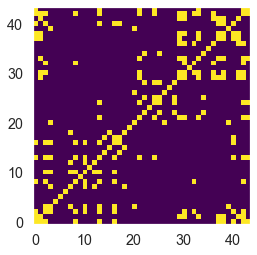

In [29]:
X_rp = RecurrencePlot().set_params(**PARAMETROS_RP).fit_transform(X)
plt.imshow(X_rp[0,:], cmap='viridis', origin='lower')
plt.grid(False)

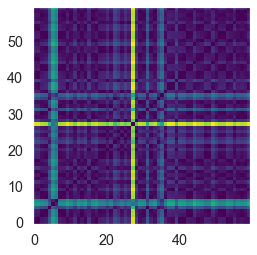

In [31]:
PARAMETROS_RP2 = {
    "dimension": 1,
    "time_delay": 1,
    "threshold": None,
    "percentage": 10
}
X_rp = RecurrencePlot().set_params(**PARAMETROS_RP2).fit_transform(X)
plt.imshow(X_rp[0,:], cmap='viridis', origin='lower')
plt.grid(False)

In [32]:
X_rp

array([[[0.        , 0.00582504, 0.05967903, ..., 0.0553112 ,
         0.03347778, 0.0363903 ],
        [0.00582504, 0.        , 0.06550407, ..., 0.06113625,
         0.03930283, 0.03056526],
        [0.05967903, 0.06550407, 0.        , ..., 0.00436783,
         0.02620125, 0.09606934],
        ...,
        [0.0553112 , 0.06113625, 0.00436783, ..., 0.        ,
         0.02183342, 0.09170151],
        [0.03347778, 0.03930283, 0.02620125, ..., 0.02183342,
         0.        , 0.06986809],
        [0.0363903 , 0.03056526, 0.09606934, ..., 0.09170151,
         0.06986809, 0.        ]],

       [[0.        , 0.05205345, 0.01862383, ..., 0.4054451 ,
         0.41977167, 0.39064074],
        [0.05205345, 0.        , 0.03342962, ..., 0.45749855,
         0.47182512, 0.44269419],
        [0.01862383, 0.03342962, 0.        , ..., 0.42406893,
         0.4383955 , 0.40926456],
        ...,
        [0.4054451 , 0.45749855, 0.42406893, ..., 0.        ,
         0.01432657, 0.01480436],
        [0.4

In [39]:
X_rp[0,:].min()

0.0